In [1]:
# We will import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Reading the data

df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As we can see that the dataset contains three unnamed columns with null values. So we drop those columns and rename the columns v1 and v2 to label and Text, respectively. Since the target variable is in string form, we will encode it numerically using pandas function .map().

In [4]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


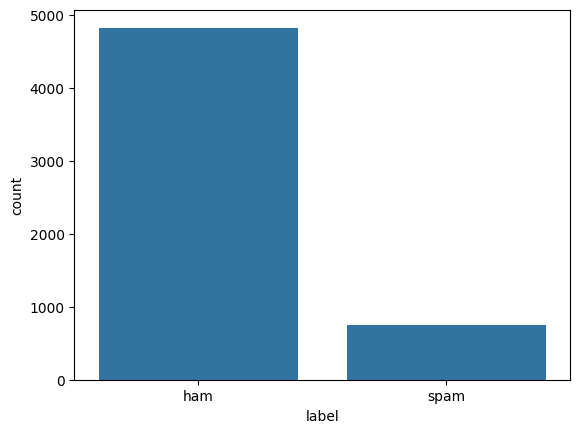

In [5]:
sns.countplot(x=df['label'])
plt.show()

The ham data is comparatively higher than spam data, it’s natural. Since we are going to use embeddings in our deep learning model, we need not balance the data. Now, let’s find the average number of words in all the sentences in SMS data.

In [6]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [7]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [8]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

Building the models
First, we will build a baseline model and then we’ll try to beat the performance of the baseline model using deep learning models (embeddings, LSTM, etc)

Here, we will choose MultinomialNB(), which performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors. The tf-idf is a measure that tells how important or relevant a word is the document.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [11]:
nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



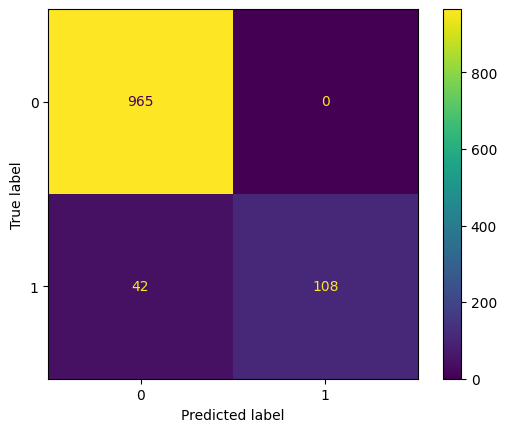

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, baseline_model.predict(X_test_vec))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

import matplotlib.pyplot as plt
plt.show()

Creating custom Text vectorization and embedding layers:

In [16]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [17]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [18]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [19]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [20]:
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 9s 51ms/step - loss: 0.6101 - accuracy: 0.8981 - val_loss: 0.5778 - val_accuracy: 0.9686
Epoch 2/5
140/140 [==============================] - 7s 52ms/step - loss: 0.5708 - accuracy: 0.9865 - val_loss: 0.5735 - val_accuracy: 0.9812
Epoch 3/5
140/140 [==============================] - 7s 51ms/step - loss: 0.5660 - accuracy: 0.9951 - val_loss: 0.5726 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 7s 54ms/step - loss: 0.5643 - accuracy: 0.9980 - val_loss: 0.5727 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 6s 44ms/step - loss: 0.5636 - accuracy: 0.9991 - val_loss: 0.5725 - val_accuracy: 0.9821


<Axes: >

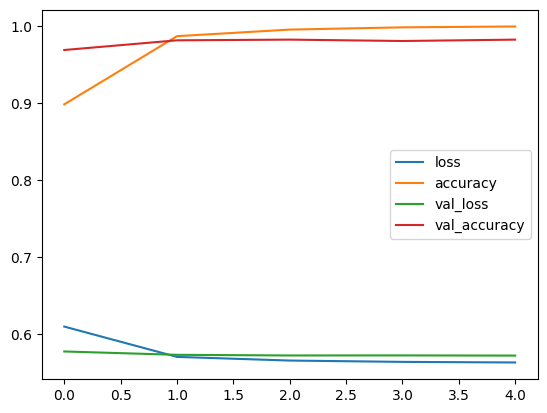

In [21]:
pd.DataFrame(history_1.history).plot()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}

    return model_results_dict

Model -2 Bidirectional LSTM

In [23]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Epoch 1/5
140/140 [==============================] - 35s 157ms/step - loss: 0.0607 - accuracy: 0.9796 - val_loss: 0.1288 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 19s 134ms/step - loss: 4.3490e-04 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 0.9722
Epoch 3/5
140/140 [==============================] - 19s 138ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.1416 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 20s 140ms/step - loss: 4.0078e-05 - accuracy: 1.0000 - val_loss: 0.1456 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 20s 142ms/step - loss: 1.7580e-05 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.9821


Model -3 Transfer Learning with USE Encoder

In [24]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 11s 43ms/step - loss: 0.2835 - accuracy: 0.9226 - val_loss: 0.1129 - val_accuracy: 0.9677
Epoch 2/5
140/140 [==============================] - 5s 38ms/step - loss: 0.0803 - accuracy: 0.9798 - val_loss: 0.0712 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 5s 38ms/step - loss: 0.0560 - accuracy: 0.9834 - val_loss: 0.0589 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 6s 41ms/step - loss: 0.0458 - accuracy: 0.9859 - val_loss: 0.0544 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 5s 39ms/step - loss: 0.0391 - accuracy: 0.9861 - val_loss: 0.0532 - val_accuracy: 0.9839


In [25]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 [==============================] - 1s 18ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.982960,0.978102,0.893333,0.933798
Bidirectional-LSTM Model,0.982063,0.957746,0.906667,0.931507
USE-Transfer learning Model,0.983857,0.971429,0.906667,0.937931


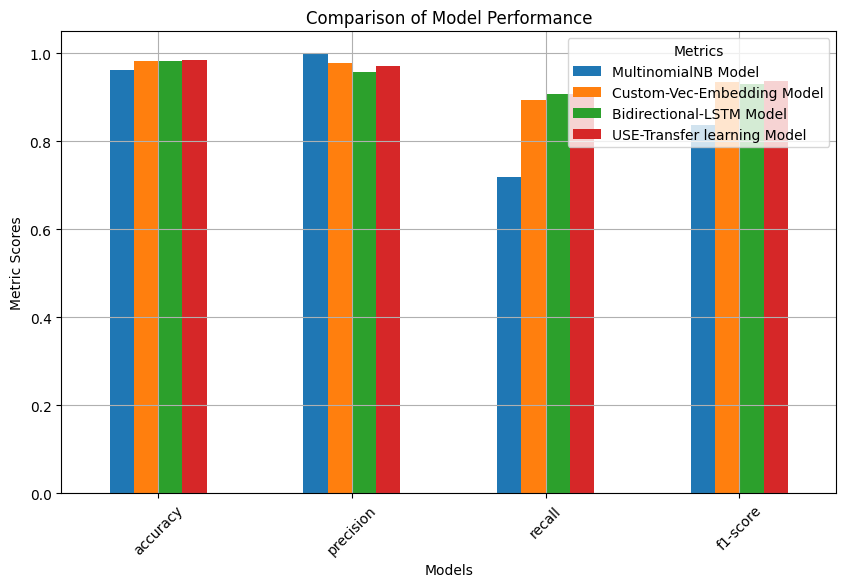

In [26]:
import matplotlib.pyplot as plt

# Assuming total_results DataFrame is structured with each row as a model and each column as a performance metric
# Transposing the DataFrame for easier plotting if necessary (depends on how metrics are stored)
total_results = total_results.transpose()

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and a set of subplots with a custom figure size

# Plotting each column as a separate bar in the bar chart
total_results.plot(kind='bar', ax=ax)

# Adding titles and labels
ax.set_title('Comparison of Model Performance')
ax.set_ylabel('Metric Scores')
ax.set_xlabel('Models')
ax.legend(title='Metrics')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Optional: Adding a grid for easier readability of the plot
ax.grid(True)

# Show the plot
plt.show()